# Proposed Conference Talk: Comparison of Deterministic and Stochastic Methods for Manpower Requirements Determination

The following is an analysis for a proposed presentation at an upcoming operations research symposium.  This analysis uses a toy example for a manpower requirements determination process and compares a current technique (i.e., Operational Audit) with a simulation-based approach.

The hypothetical function under study, in keeping with my previous toy examples, is Corporate Co.  The function Corporate Co. resides at 80 locations and each location perform the following 10 processes:

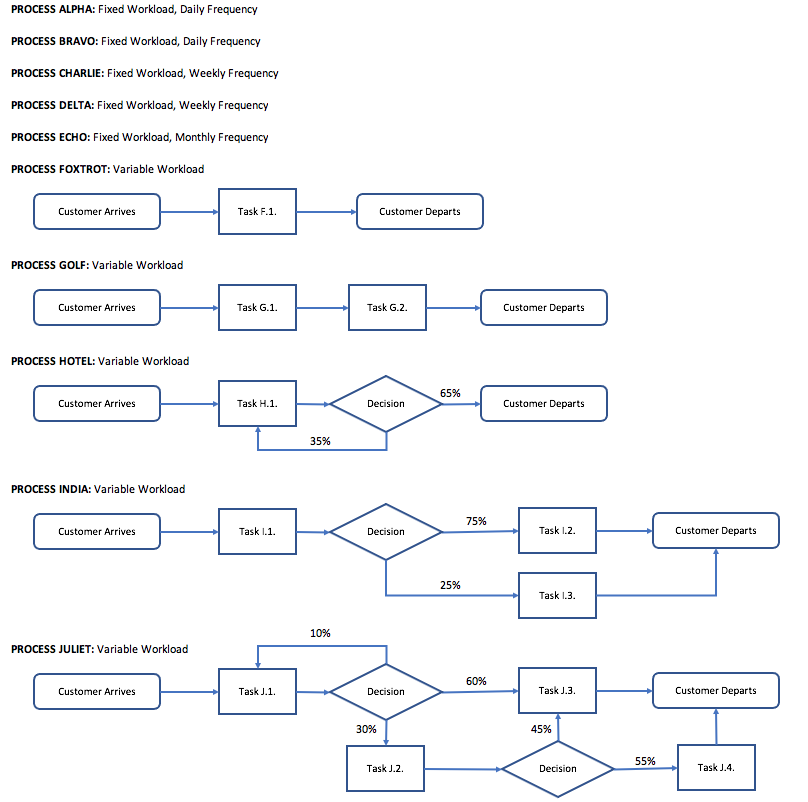

## Data Collection: Process Times

To conduct this study, the team hypothetically selects 12 locations at random and asks each of these locations to gather process time data for 30 days.  After the 30 days, the time data is collected and reviewed for consistency.  Let's assume that no bases show irregularities in measurement data.  The following process & task times are gathered:

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import simpy
import statistics

random.seed(123)                         # Seed the random number generator
alpha_times = []                         # Initialize list for Process Alpha times
bravo_times = []                         # Initialize list for Process Bravo times
charlie_times = []                       # Initialize list for Process Charlie times
delta_times = []                         # Initialize list for Process Delta times
echo_times = []                          # Initialize list for Process Echo times
foxtrot_1_times = []                     # Initialize list for Task F.1. times
golf_1_times = []                        # Initialize list for Task G.1. times
golf_2_times = []                        # Initialize list for Task G.2. times
hotel_1_times = []                       # Initialize list for Task H.1. times
india_1_times = []                       # Initialize list for Task I.1. times
india_2_times = []                       # Initialize list for Task I.2. times
india_3_times = []                       # Initialize list for Task I.3. times
juliet_1_times = []                      # Initialize list for Task J.1. times
juliet_2_times = []                      # Initialize list for Task J.2. times
juliet_3_times = []                      # Initialize list for Task J.3. times
juliet_4_times = []                      # Initialize list for Task J.4. times

for i in range(360):                                # 30 daily measurements from 12 bases
    alpha_times.append(random.randint(35, 55))      # Process Alpha takes between 35 - 55 min
    bravo_times.append(random.randint(23, 47))      # Process Bravo takes between 23 - 47 min

for i in range(48):                                 # 4 weekly measurements from 12 bases
    charlie_times.append(random.randint(90, 130))   # Process Charlie takes between 90 - 130 min
    delta_times.append(random.randint(120, 130))    # Process Delta takes between 120 - 150 min
    
for i in range(12):                                 # 1 monthly measurement from 12 bases
    echo_times.append(random.randint(70, 95))       # Process Echo takes between 70-95 min

for i in range(600):                                # 50 task measurements from 12 bases
    foxtrot_1_times.append(random.randint(20, 40))  # Task F.1. takes between 20 - 40 min
    golf_1_times.append(random.randint(35, 50))     # Task G.1. takes between 35 - 50 min
    golf_2_times.append(random.randint(15, 27))     # Task G.2. takes between 15 - 27 min
    hotel_1_times.append(random.randint(30, 45))    # Task H.1. takes between 30 - 45 min
    india_1_times.append(random.randint(10, 18))    # Task I.1. takes between 10 - 18 min
    india_2_times.append(random.randint(5, 20))     # Task I.2. takes between 5 - 20 min
    india_3_times.append(random.randint(20, 37))    # Task I.3. takes between 20 - 37 min
    juliet_1_times.append(random.randint(15, 25))   # Task J.1. takes between 15 - 25 min
    juliet_2_times.append(random.randint(30, 50))   # Task J.2. takes between 30 - 50 min
    juliet_3_times.append(random.randint(25, 60))   # Task J.3. takes between 25 - 60 min
    juliet_4_times.append(random.randint(5, 25))    # Task J.4. takes between 5 - 25 min

## Operational Audit: Calculating Standard Activity Time

Under the operational audit technique, the average process time is computed and referred to as the 'standard activity time', or SAT.  To calculate this, compute the average time for each task (if applicable) and multiply it by the frequency at which that task occurs whenever the process is initiated.

In [2]:
alpha_SAT = np.mean(alpha_times)
bravo_SAT = np.mean(bravo_times)
charlie_SAT = np.mean(charlie_times)
delta_SAT = np.mean(delta_times)
echo_SAT = np.mean(echo_times)
foxtrot_SAT = np.mean(foxtrot_1_times)
golf_SAT = np.mean(golf_1_times) + np.mean(golf_2_times)
hotel_SAT = np.mean(hotel_1_times) * 1.35
india_SAT = np.mean(india_1_times) + np.mean(india_2_times) * 0.75 + np.mean(india_3_times) * 0.25
juliet_SAT = np.mean(juliet_1_times) * 1.10 + np.mean(juliet_2_times) * 0.30 + np.mean(juliet_3_times) * (0.60 + 0.30 * 0.45) + np.mean(juliet_4_times) * (0.30 * 0.55)

## Simulation-Based Approach: Bootstrapping Process Sample Distributions

Under the simulation-based approach, the time for each process is represented as a distribution of likely times.  To generate these distributions, we will bootstrap the measurement data.  According to the Central Limit Theorem, this will yeild a normal distribution.  The only potential caveat to the theorem for this toy example is process echo, which might have too few measurements to guarantee a normal distribution.

In [3]:
# The function bootstrap_replicate generates a 1-dimensional bootstrap replicate from a 1-dimensional array of data
# The function returns whatever operation is requested to be performed on the replicate, often np.mean
def bootstrap_replicate(data, func):
    replicate = np.random.choice(data, len(data))
    return func(replicate)

# The function draw_bs_reps takes a 1-dimensional array of data and generates 'size' number of replicates
# The function returns an array of data that is gathered from each bootstrap replicate, determined by...
# ...func (often np.mean)
def draw_bs_reps(data, func, size = 1000):
    #Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    #Generate 'size' number of replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate(data, func)
    
    return bs_replicates

For the processes without multiple tasks or task frequencies deviating from 1, we can simply apply the above functions.  For the processes with multiple tasks and task frequencies, however, we will utilize two properties for independent normal distributions:
- Assume X is normally distributed.  If Y = aX + b, where a and b are constant values, then Y is normally distributed with E[Y] = a E[X] + b and Var[Y] = a<sup>2</sup> Var[X] (thus StdDev[Y] = a StdDev[X]).
- Assume X and Y are both normally distributed.  If Z = X + Y, then Z is normally distributed with E[Z] = E[X] + E[Y] and Var[Z] = Var[X] + Var[Y].

In [4]:
# Run the above bootstrapping functions on each process/task generating sample mean distribution over 10,000 replicates
A = draw_bs_reps(alpha_times, np.mean, 10000)
B = draw_bs_reps(bravo_times, np.mean, 10000)
C = draw_bs_reps(charlie_times, np.mean, 10000)
D = draw_bs_reps(delta_times, np.mean, 10000)
E = draw_bs_reps(echo_times, np.mean, 10000)
F1 = draw_bs_reps(foxtrot_1_times, np.mean, 10000)
G1 = draw_bs_reps(golf_1_times, np.mean, 10000)
G2 = draw_bs_reps(golf_2_times, np.mean, 10000)
H1 = draw_bs_reps(hotel_1_times, np.mean, 10000)
I1 = draw_bs_reps(india_1_times, np.mean, 10000)
I2 = draw_bs_reps(india_2_times, np.mean, 10000)
I3 = draw_bs_reps(india_3_times, np.mean, 10000)
J1 = draw_bs_reps(juliet_1_times, np.mean, 10000)
J2 = draw_bs_reps(juliet_2_times, np.mean, 10000)
J3 = draw_bs_reps(juliet_3_times, np.mean, 10000)
J4 = draw_bs_reps(juliet_4_times, np.mean, 10000)

# Knowing that the bootstrapping functions will yield normally distributed process times, identify mean and std dev
alpha_mean, alpha_std = A.mean(), A.std()
bravo_mean, bravo_std = B.mean(), B.std()
charlie_mean, charlie_std = C.mean(), C.std()
delta_mean, delta_std = D.mean(), D.std()
echo_mean, echo_std = E.mean(), E.std()
foxtrot_mean, foxtrot_std = F1.mean(), F1.std()
golf_mean, golf_std = G1.mean() + G2.mean(), G1.std() + G2.std()
hotel_mean, hotel_std = H1.mean() * 1.35, H1.std() * 1.35
india_mean, india_std = I1.mean() + I2.mean() * 0.75 + I3.mean() * 0.25, I1.std() + I2.std() * 0.75 + I3.std() * 0.25
juliet_mean, juliet_std = J1.mean() * 1.10 + J2.mean() * 0.30 + J3.mean() * (0.60 + 0.30 * 0.45) + J4.mean() * (0.30 * 0.55), J1.std() * 1.10 + J2.std() * 0.30 + J3.std() * (0.60 + 0.30 * 0.45) + J4.std() * (0.30 * 0.55)

## Data Collection: Customer Throughput

After gathering measurement times from select bases and modeling Corporate Co's process time, the study team then gathered data on the customer throughput of all each of the 80 locations where the Corporate Co function exists.  Specifically, each location provided the number of customers that they saw each month, for each of the customer-driven processes.

In [5]:
customer_data = []                                           # Initialize customer data list

for base in range(1, 81):                                    # For each of the 80 locations
    foxtrot_cust = []                                        # Initialize foxtrot list
    golf_cust = []                                           # Initialize golf list
    hotel_cust = []                                          # Initialize hotel list
    india_cust = []                                          # Initialize india list
    juliet_cust = []                                         # Initialize juliet list
    F_lambda = random.randint(150, 270)                      # Randomly select foxtrot avg
    G_lambda = random.randint(230, 350)                      # Randomly select golf avg
    H_lambda = random.randint(50, 175)                       # Randomly select hotel avg
    I_lambda = random.randint(75, 215)                       # Randomly select india avg
    J_lambda = random.randint(200, 400)                      # Randomly select juliet avg
#    for month in range(12):                                  # For each month in the year
#        foxtrot_cust.append(np.random.poisson(F_lambda))     # Determine number of foxtrot cust
#        golf_cust.append(np.random.poisson(G_lambda))        # Determine number of golf cust
#        hotel_cust.append(np.random.poisson(H_lambda))       # Determine number of hotel cust
#        india_cust.append(np.random.poisson(I_lambda))       # Determine number of india cust
#        juliet_cust.append(np.random.poisson(J_lambda))      # Determine number of juliet cust

# Let's assume the monthly customer levels are normally distributed
    for month in range(12):                                  # For each month in the year
        foxtrot_cust.append(np.random.normal(F_lambda, F_lambda/5))     # Determine number of foxtrot cust
        golf_cust.append(np.random.normal(G_lambda, G_lambda/5))        # Determine number of golf cust
        hotel_cust.append(np.random.normal(H_lambda, H_lambda/5))       # Determine number of hotel cust
        india_cust.append(np.random.normal(I_lambda, I_lambda/5))       # Determine number of india cust
        juliet_cust.append(np.random.normal(J_lambda, J_lambda/5))      # Determine number of juliet cust
    customer_data.append({'Base': f'Base {base}', 'Foxtrot': foxtrot_cust, 'Golf': golf_cust, 'Hotel': hotel_cust, 'India': india_cust, 'Juliet': juliet_cust})
    
customer_df = pd.DataFrame(customer_data).set_index('Base')  # Convert list of dict into df

## Operational Audit: Calculating Monthly Manhours

Under the operational audit technique, the customer throughput data is averaged by process and multiplied by the applicable SAT.  This will provide the average workload for each month.  This value is that converted to hours to provide monthly manhours (MMHs).

In [6]:
MMH_list = []                                                # Initialize the MMH list

for base in range(1, 81):                                    # For each of the 80 bases
    alpha_MMH = (alpha_SAT * 20.91) / 60                     # Convert daily process to MMH
    bravo_MMH = (bravo_SAT * 20.91) / 60                     # Convert daily process to MMH
    charlie_MMH = (charlie_SAT * 4.348) / 60                 # Convert weekly process to MMH
    delta_MMH = (delta_SAT * 4.348) / 60                     # Convert weekly process to MMH
    echo_MMH = (echo_SAT * 1.000) / 60                       # Convert monthly process to MMH
    
    # For customer-driven processes, multiply the SAT by the average monthly customers
    foxtrot_MMH = (foxtrot_SAT * np.mean(customer_df.loc[f'Base {base}']['Foxtrot'])) / 60
    golf_MMH = (golf_SAT * np.mean(customer_df.loc[f'Base {base}']['Golf'])) / 60
    hotel_MMH = (hotel_SAT * np.mean(customer_df.loc[f'Base {base}']['Hotel'])) / 60
    india_MMH = (india_SAT * np.mean(customer_df.loc[f'Base {base}']['India'])) / 60
    juliet_MMH = (juliet_SAT * np.mean(customer_df.loc[f'Base {base}']['Juliet'])) / 60
    MMH_list.append({'Base': f'Base {base}', 'MMH': alpha_MMH + bravo_MMH + charlie_MMH + delta_MMH + echo_MMH + foxtrot_MMH + golf_MMH + hotel_MMH + india_MMH + juliet_MMH})

OA_MMH_df = pd.DataFrame(MMH_list).set_index('Base')                 # Construct a dataframe of MMH, by base
IAF = 1.0619                                                         # Define indirect allowance factor
MAF = 148.79                                                         # Define the manpower availability factor
OA_MMH_df['Fractional Manpower'] = (OA_MMH_df['MMH'] * IAF) / MAF    # Compute Fractional Manpower
OA_MMH_df

,MMH,Fractional Manpower
Base,,
Base 1,1028.196680,7.338141
Base 2,978.100813,6.980612
Base 3,907.869125,6.479375
Base 4,875.822126,6.250659
Base 5,985.853962,7.035945
...,...,...
Base 76,1139.638091,8.133488
Base 77,856.386766,6.111950
Base 78,1042.752124,7.442022


## Simulation Based Approach: Calculating Corporate Co's Requirements and Risk

Under the simulation-based approach, manpower requirements are determined by observing the output of a simulation of probabilistically-likely workload over a period of time.  This provides insights into the impact that varying the manning of the function would have on operational effectiveness.

As it is currently written, the below script inputs (1) which of the 80 bases you would like to study, (2) the employee range you would like to explore, and (3) the duration you want the simulation to run for each of the employee-based scenarios.  For purposes of comparison, the manpower as determined by the operational audit is depicted as a dashed reference line on the generated plots.

Note: The current number of hours in the duty day for this scenario is calculated based on the MAF and the monthly conversion factor (20.91).  As the MAF represents the expected available work performed by employees each month, that expectation is thus built into the scenario.  Additionally, each customer transaction is adjusted accordingly by the indirect allowance factor (IAF) to replicate the manner in which it is included in the Operational Audit method.  To demonstrate:

- Under operational audit, we compute: MMH * IAF
- To determine MMH, we total the duration of each transaction: MMH = (process time #1) + (process time #2) + ... + (process time #n)
- Therefore, MMH * IAF = [(process time #1) + (process time #2) + ... + (process time #n)] * IAF = (process time #1)(IAF) + (process time #2)(IAF) + ... + (process time #n)(IAF)

Which base would you like to simulate?  Base 1
What is the lowest number of employees you want to consider?  1
What is the highest number of employees you want to consider?  15
How many days would you like each simulation to run for?  150


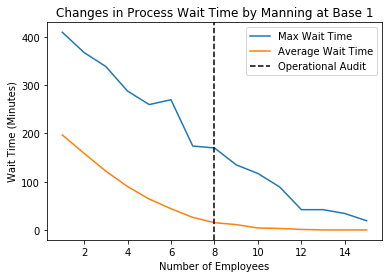

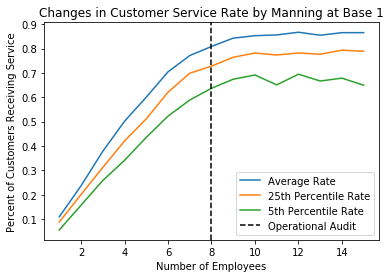

In [7]:
# Define the class 'CorporateCo' which houses functions for each process
# When a process is called, the simulator calls the particular process and adjusts the time...
# ...to reflect the process time as defined by our previously determined distributions.
class CorporateCo(object):
    # Set each team as attributes of service when the class is called
    def __init__(self, env, num_employee):
        self.env = env
        self.employee = simpy.Resource(env, num_employee)
        
    # Define functions for each process and set the process time
    def alpha(self, env, customer, day, wait):
        prcs_time = np.random.normal(alpha_mean, alpha_std)*IAF
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Alpha', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def bravo(self, env, customer, day, wait):
        prcs_time = np.random.normal(bravo_mean, bravo_std)*IAF                                      
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Bravo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def charlie(self, env, customer, day, wait):
        prcs_time = np.random.normal(charlie_mean, charlie_std)*IAF         
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Charlie', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def delta(self, env, customer, day, wait):
        prcs_time = np.random.normal(delta_mean, delta_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Delta', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def echo(self, env, customer, day, wait):                                
        prcs_time = np.random.normal(echo_mean, echo_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Echo', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})

    def foxtrot(self, env, customer, day, wait):
        prcs_time = np.random.normal(foxtrot_mean, foxtrot_std)*IAF
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Foxtrot', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def golf(self, env, customer, day, wait):
        prcs_time = np.random.normal(golf_mean, golf_std)*IAF                                      
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Golf', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def hotel(self, env, customer, day, wait):
        prcs_time = np.random.normal(hotel_mean, hotel_std)*IAF         
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Hotel', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def india(self, env, customer, day, wait):
        prcs_time = np.random.normal(india_mean, india_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'India', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})
        
    def juliet(self, env, customer, day, wait):                                
        prcs_time = np.random.normal(juliet_mean, juliet_std)*IAF 
        start = env.now
        yield self.env.timeout(prcs_time)
        complete = env.now
        roster.append({'Day': day, 'Process': 'Juliet', 'Wait': wait, 'Start Time': start, 'Duration': prcs_time, 'Departure Time': complete})


# Define the function visit_office to direct the actions of the customer once they arrive
def visit_office(env, customer, office, day, base):
    # Set arrival_time equal to the time this function starts (i.e., customer arrives)
    arrival_time = env.now
        
    # Draw a random number from 0 to 1
    rand_draw = random.random()
    
    # From the customer throughput data, compute the average number of customers for each process
    f_num = np.mean(customer_df.loc[base]['Foxtrot'])
    g_num = np.mean(customer_df.loc[base]['Golf'])
    h_num = np.mean(customer_df.loc[base]['Hotel'])
    i_num = np.mean(customer_df.loc[base]['India'])
    j_num = np.mean(customer_df.loc[base]['Juliet'])
    # Total the average number of customers for each process
    tot_num = (f_num + g_num + h_num + i_num + j_num)
    
    # Based on the random number and the probabilities of different services being requested...
    # ...customers will be funneled to the previously defined functions in class CorporateCo
    # Customers will request the service from a team member and wait until it is provided
    # Once a team member becomes available, the wait time will be calculated and stored
    if rand_draw <= f_num / tot_num:                                 
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.foxtrot(env, customer, day, wait))
    
    elif rand_draw <= (f_num + g_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.golf(env, customer, day, wait))

    elif rand_draw <= (f_num + g_num + h_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.hotel(env, customer, day, wait))
            
    elif rand_draw <= (f_num + g_num + h_num + i_num) / tot_num:                               
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.india(env, customer, day, wait))

    else:
        with office.employee.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times.append(wait)
            yield env.process(office.juliet(env, customer, day, wait))
            
# Define the function visit_office_day to direct daily workload
def visit_office_daily(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.alpha(env, customer, day, wait))
        
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.bravo(env, customer, day, wait))
        
# Define the function visit_office_monthly to direct daily workload
def visit_office_weekly(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.charlie(env, customer, day, wait))
        
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.delta(env, customer, day, wait))

# Define the function visit_office_monthly to direct daily workload
def visit_office_monthly(env, customer, office, day):
    arrival_time = env.now
    with office.employee.request() as request:
        yield request
        wait = env.now - arrival_time
        yield env.process(office.echo(env, customer, day, wait))


# Define the function run_office which inputs the simulation's workforce, initializes the...
# ...customers waiting in the lobby when the office opens, and then periodically sends...
# ...customers into the office throughout the day.
def run_office(env, num_employee, day, base):
    office = CorporateCo(env, num_employee)
    customer = 1
    # Call daily workload
    env.process(visit_office_daily(env, customer, office, day))
    
    # Call weekly workload
    if day in np.arange(0, 300, 5):  
        env.process(visit_office_weekly(env, customer, office, day))
        
    if day in np.arange(0, 300, 21):  
        env.process(visit_office_monthly(env, customer, office, day))
    
    # From the customer throughput data, compute the average number of customers for each process
    f_num = np.mean(customer_df.loc[base]['Foxtrot'])
    g_num = np.mean(customer_df.loc[base]['Golf'])
    h_num = np.mean(customer_df.loc[base]['Hotel'])
    i_num = np.mean(customer_df.loc[base]['India'])
    j_num = np.mean(customer_df.loc[base]['Juliet'])
    # Based on total customers, draw from a normal distribution of the customers
    tot_num = math.ceil(np.random.normal((f_num + g_num + h_num + i_num + j_num) / 20.91, (f_num + g_num + h_num + i_num + j_num) / (5 * 20.91)))
    # Store the number the customers that arrived during the day
    tot_cust_arr.append(tot_num)
    
    # Evenly spaces the daily customers across the day and adds them to the simulation
    # While the number of customers is less than the total daily customers:
    i = 0
    while i < tot_num:
        yield env.timeout(np.random.exponential(((MAF / 20.91) * 60) / tot_num)) 
        i += 1
        customer += 1
        env.process(visit_office(env, customer, office, day, base))
        
# Define function calculate_wait_times to compute the average wait time at the each of the...
# ...simulation and convert it to a more readable format.
def average_wait_times(wait_times):
    average_wait = statistics.mean(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

def max_wait_times(wait_times):
    max_wait = np.max(wait_times)
    minutes, frac_minutes = divmod(max_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

# The function main serves as the core function which initiates the simulation and sets the...
# ...overarching parameters
def main(base, num_employee, num_days):
    # Seed the random number generators to make results reproducible 
    random.seed(42)
    np.random.seed(42)
    
    cust_start = []
    
    for day in range(num_days):        
        # Run simulation and set the duration (in minutes) for the simulation to run
        env = simpy.Environment()
        env.process(run_office(env, num_employee, day, base))
        env.run(until = (MAF / 20.91) * 60)                           

    # View the results
    mins, secs = average_wait_times(wait_times)
    mins_max, secs_max = max_wait_times(wait_times)
    
    # Convert the process roster into a dataframe and display
    process_roster = pd.DataFrame(roster)
    
    fixed_var = ['Alpha', 'Bravo', 'Charlie', 'Delta', 'Echo']
    a = process_roster[~process_roster.Process.isin(fixed_var)].groupby(['Day']).count()[['Process']]
    b = pd.DataFrame(tot_cust_arr)
    a = b.join(a, how = 'outer').rename(columns = {0: 'Customers Arrived', "Process": 'Customers Served'})
    a['Completion Rate'] = a['Customers Served'] / a['Customers Arrived']
    completion_rate = a['Completion Rate'].mean()
    completion_rate_min = np.percentile(a['Completion Rate'], 5)
    completion_rate_25 = np.percentile(a['Completion Rate'], 25)
    del process_roster
    return mins, completion_rate, completion_rate_min, completion_rate_25, mins_max

# Calls the main function to start the simulation
# Collect the input variables
base = input('Which base would you like to simulate?  ')
low_bound = int(input('What is the lowest number of employees you want to consider?  '))
high_bound = int(input('What is the highest number of employees you want to consider?  '))
length = int(input('How many days would you like each simulation to run for?  '))
# Initialize arrays used to store outputs of each iteration of simulation run
min_arr = []
max_min_arr = []
comp_rate_arr = []
comp_rate_min_arr = []
comp_rate_25_arr = []
# Run the simulation for as many scenarios as requested by the user
for i in range(low_bound, high_bound + 1):
    roster = []                                    # Initialize the transaction registry (used in sim)
    wait_times = []                                # Initialize the wait time array (used in sim)
    tot_cust_arr = []                              # Initialize the total customer array (used in sim)
    tot_cust_start = []
    a, b, c, d, e = main(base, i, length)          # Run simulation & store outputs in variables a - e
    min_arr.append(a)
    comp_rate_arr.append(b)
    comp_rate_min_arr.append(c)
    comp_rate_25_arr.append(d)
    max_min_arr.append(e)

# Define the x-axis to represent the number of employees working in the office for each scenario
x = np.arange(low_bound, high_bound + 1)

# Plot the wait time for each employee-based scenario
plt.plot(x, max_min_arr, label = 'Max Wait Time')
plt.plot(x, min_arr, label = 'Average Wait Time')
plt.axvline(x = math.ceil(OA_MMH_df.loc[base, 'Fractional Manpower']), color = 'black', linestyle = '--', label = 'Operational Audit')
plt.xlabel('Number of Employees')
plt.ylabel('Wait Time (Minutes)')
plt.title(f'Changes in Process Wait Time by Manning at {base}')
plt.legend()
plt.show()

# Plot the % of customers to receive service for each employee-based scenario
plt.plot(x, comp_rate_arr, label = 'Average Rate')
plt.plot(x, comp_rate_25_arr, label = '25th Percentile Rate')
plt.plot(x, comp_rate_min_arr, label = '5th Percentile Rate')
plt.axvline(x = math.ceil(OA_MMH_df.loc[base, 'Fractional Manpower']), color = 'black', linestyle = '--', label = 'Operational Audit')
plt.xlabel('Number of Employees')
plt.ylabel('Percent of Customers Receiving Service')
plt.title(f'Changes in Customer Service Rate by Manning at {base}')
plt.legend()
plt.show()

## Areas of Further Research

Comparing the outputs of the simulation-based method and the operational audit, we find that the simulation-based approach offers more information related to the risk associated with varying levels of manning.  Using this approach, the following additional areas of research are possible:
- What impact do local requirements (e.g., staff meetings, professional development initiatives) have on the office operations?
- How can this simulation-based method be used to information manning decisions as new members arrive to the office?